In [1]:
!pip install -q sklearn

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def Plotter(acc,val_acc,loss,val_loss,l_r):
  
  plt.plot(acc, label='accuracy')
  plt.plot(val_acc, label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()


  plt.plot(loss, label='loss')
  plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(l_r, label='Learning Rate')
  # plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('LR')
  plt.legend(loc='lower right')
  plt.show()

In [4]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1671168/1668792 [==============================] - 0s 0us/step


In [5]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [6]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [7]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
# train

7383 train examples
1846 validation examples
2308 test examples


In [8]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [9]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([  2   1   4 120   2], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 0 0 1], shape=(5,), dtype=int64)


In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [12]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[1.074984  ],
       [0.12638645],
       [1.074984  ],
       [0.12638645],
       [0.44258562]], dtype=float32)>

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [14]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)>

In [15]:
type_col = train_features['Age']
category_encoding_layer = get_category_encoding_layer('Age', train_ds,
                                                      'int64', 5)
category_encoding_layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

In [16]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [17]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [18]:
# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [19]:
# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


In [20]:
def mymodel():
  all_features = tf.keras.layers.concatenate(encoded_features)
  x = tf.keras.layers.Dense(32, activation="relu")(all_features)
  x = tf.keras.layers.Dropout(0.5)(x)
  output = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(all_inputs, output)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])
  return model

model = mymodel()

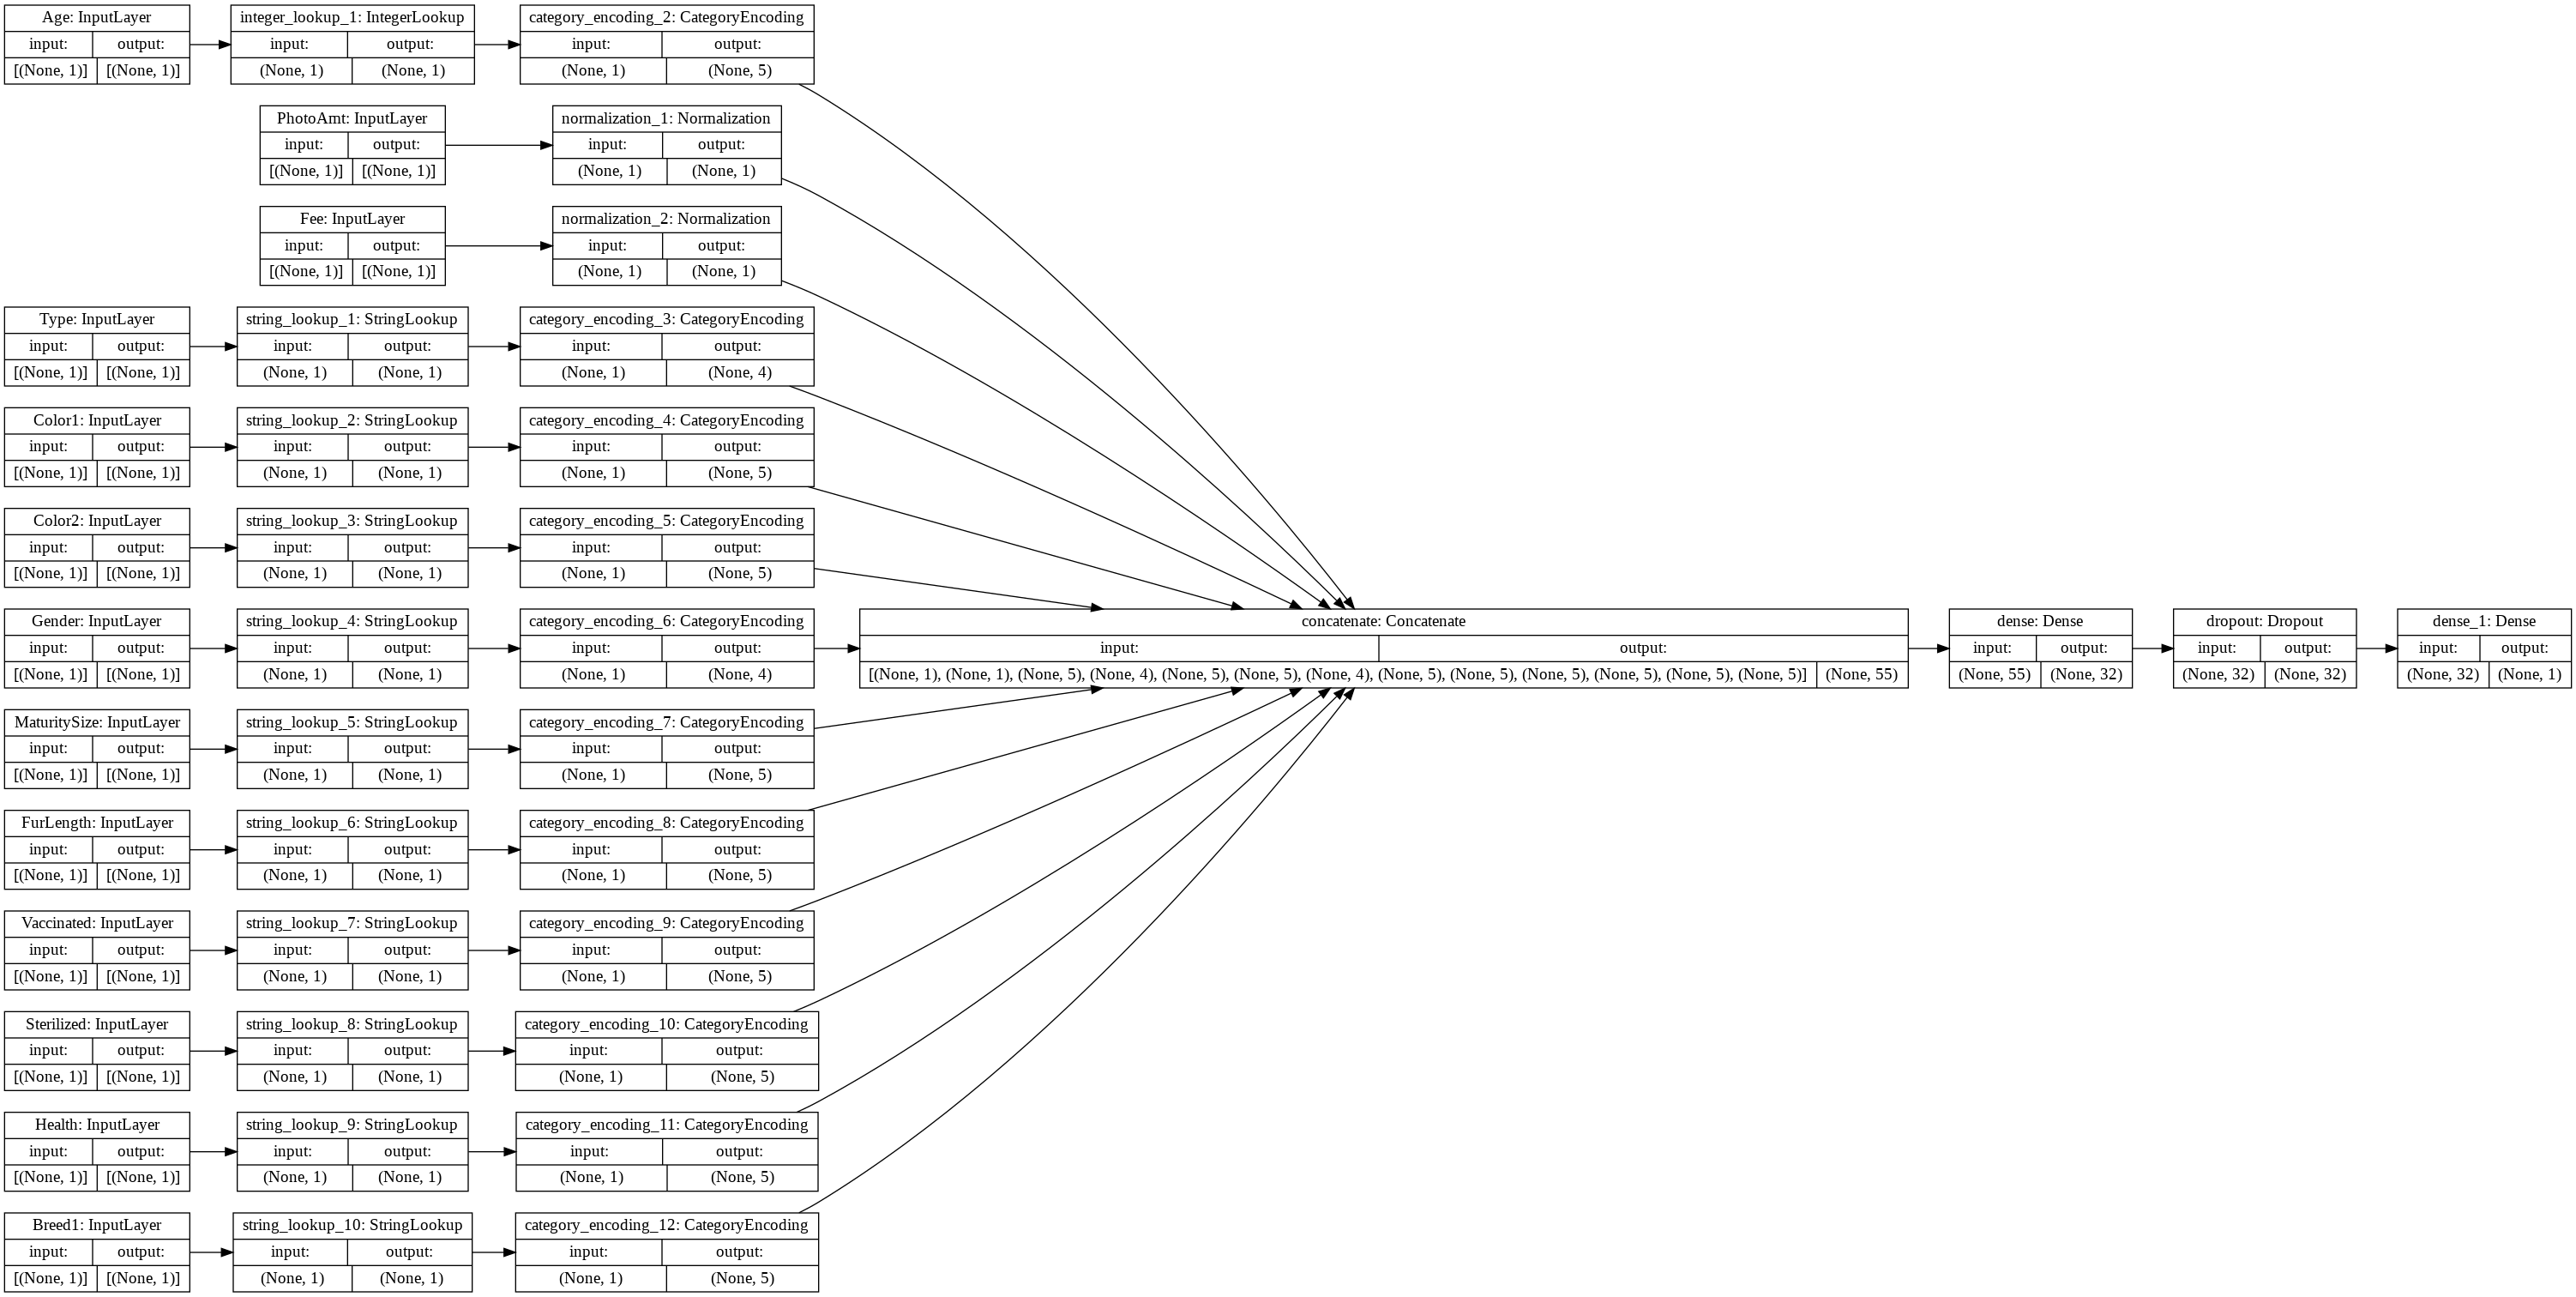

In [21]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [22]:
history = model.fit(train_ds, epochs=150, validation_data=val_ds)

Epoch 1/150
29/29 [==============================] - 2s 20ms/step - loss: 0.6798 - accuracy: 0.4597 - val_loss: 0.5938 - val_accuracy: 0.6723
Epoch 2/150
29/29 [==============================] - 0s 5ms/step - loss: 0.6067 - accuracy: 0.6338 - val_loss: 0.5624 - val_accuracy: 0.7243
Epoch 3/150
29/29 [==============================] - 0s 7ms/step - loss: 0.5797 - accuracy: 0.6638 - val_loss: 0.5466 - val_accuracy: 0.7308
Epoch 4/150
29/29 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.6886 - val_loss: 0.5377 - val_accuracy: 0.7319
Epoch 5/150
29/29 [==============================] - 0s 6ms/step - loss: 0.5515 - accuracy: 0.7020 - val_loss: 0.5309 - val_accuracy: 0.7248
Epoch 6/150
29/29 [==============================] - 0s 7ms/step - loss: 0.5467 - accuracy: 0.7020 - val_loss: 0.5272 - val_accuracy: 0.7324
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 0.5375 - accuracy: 0.7089 - val_loss: 0.5238 - val_accuracy: 0.7291
Epoch 8/150


In [23]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']

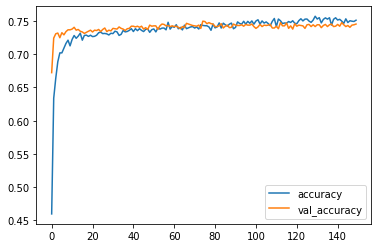

In [24]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

Test LR

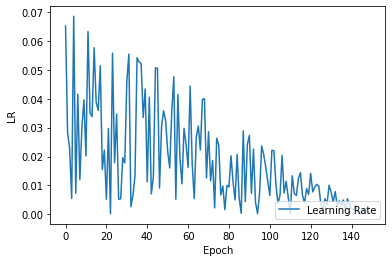

In [28]:
from random import random,randint,randrange,uniform
lr = []
epoo=150
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  # print(z,(batch_size)/((z+1)**(3/2))/80)
  


  # if (z%2 == 0):
  LR = random() * batch_size/10000
  lr.append(LR)
  # else:
  #   LR = random() * z/10000
  #   lr.append(LR)

lr = lr[::-1] 
lord_LR = lr
# print(min(lr))


plt.plot(lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

Our Method 

LR ∝ BS/Epoch

In [29]:
from keras.callbacks import LearningRateScheduler
from random import random
model = mymodel()
# from keras.callbacks import LearningRateScheduler
epoo = 150
LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []

num = 0

x = 0
# kr = lr
for z,batch_size in zip(range(1,epoo),range(5,10000,5)):

  # if (z%2 == 0):
  LR = random() * batch_size/10000
  lr.append(LR)
  # else:
  #   LR = random() * z/10000
  # lr.append(LR)

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    global x
    global lord_LR 

    LR=lord_LR[x]
    x+=1
    if(LR>0.009):
      LR = 0.009
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]


  history = model.fit(
            train_ds, 
            validation_data=(val_ds),
            epochs=1,
            batch_size=batch_size,
            callbacks=call
            )
  



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 0.0004017116899605712, Batch Size  5 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 2s 21ms/step - loss: 0.5705 - accuracy: 0.6672 - val_loss: 0.5242 - val_accuracy: 0.7319


epoch 2, Learning Rate 0.00011625848475039613, Batch Size  10 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 0s 6ms/step - loss: 0.5259 - accuracy: 0.7139 - val_loss: 0.5134 - val_accuracy: 0.7394


epoch 3, Learning Rate 8.15571793346716e-05, Batch Size  15 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 0s 5ms/step - loss: 0.5185 - accuracy: 0.7189 - val_loss: 0.5057 - val_accuracy: 0.7351


epoch 4, Learning Rate 0.0009093819040186695, Batch Size  20 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005492010909125174.
29/29 [==============================] - 0s 5ms/step - loss: 0.514

In [30]:
acc_2 = acc
val_acc_2 = val_acc

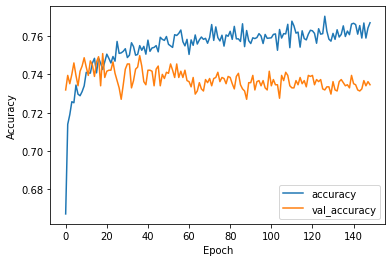

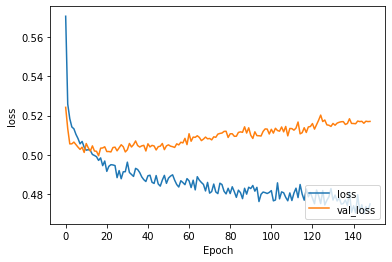

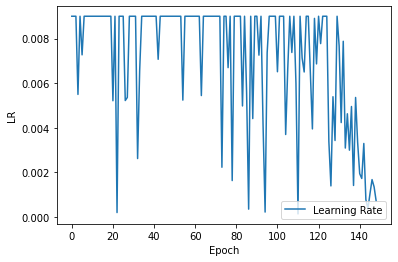

In [31]:
Plotter(acc,val_acc,loss,val_loss,l_r)

BS = const

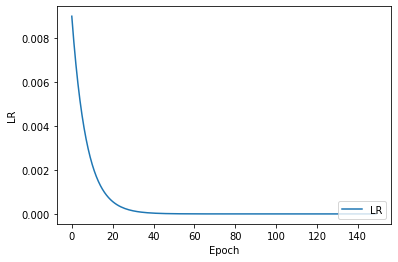

In [33]:
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
for i in range(150):
  lr = initial_learning_rate * decay_rate **(i / decay_steps)
  LR.append(lr)
plt.plot(LR, label='LR')
# plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

In [34]:
from keras.callbacks import LearningRateScheduler
from random import random
model = mymodel()

# epoo = 1
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
def setLR(step):
  global LR
  lr = initial_learning_rate * decay_rate **(step / decay_steps)
  LR.append(lr)
  # print("called here")
  return lr

call = [ LearningRateScheduler(setLR,verbose=1) ]

history = model.fit(
            train_ds, 
            validation_data=(val_ds),
            epochs=150,
            # batch_size=batch_size,
            callbacks=call
            )

# acc = []
# val_acc = []
# loss = []
# val_loss = []


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 2s 28ms/step - loss: 0.6110 - accuracy: 0.6290 - val_loss: 0.5307 - val_accuracy: 0.7161
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 0.007834955069665117.
29/29 [==============================] - 0s 5ms/step - loss: 0.5352 - accuracy: 0.7162 - val_loss: 0.5140 - val_accuracy: 0.7405
Epoch 3/150

Epoch 00003: LearningRateScheduler reducing learning rate to 0.006820724549296791.
29/29 [==============================] - 0s 5ms/step - loss: 0.5241 - accuracy: 0.7210 - val_loss: 0.5107 - val_accuracy: 0.7281
Epoch 4/150

Epoch 00004: LearningRateScheduler reducing learning rate to 0.005937785598478023.
29/29 [==============================] - 0s 7ms/step - loss: 0.5167 - accuracy: 0.7217 - val_loss: 0.5075 - val_accuracy: 0.7313
Epoch 5/150

Epoch 00005: LearningRateScheduler reducing learning rate to 0.005169142597486656.
29/29 [===========

In [35]:
acc_3 = acc
val_acc_3 = val_acc

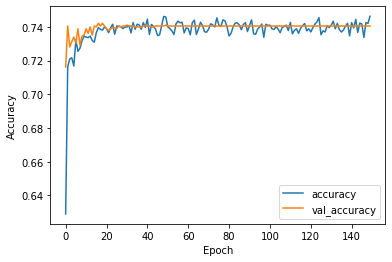

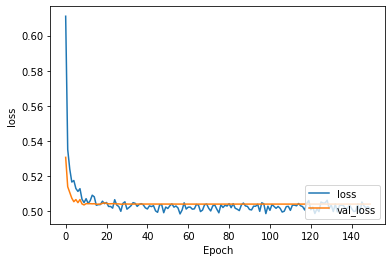

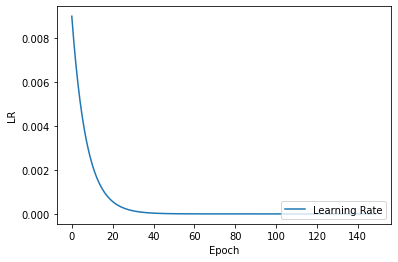

In [36]:
Plotter(acc,val_acc,loss,val_loss,LR)

LR const

In [37]:
from keras.callbacks import LearningRateScheduler
from random import random
model = mymodel()
LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []

num = 0
x = 0
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]


  history = model.fit(
            train_ds, 
            validation_data=(val_ds),
            epochs=1,
            batch_size=batch_size,
            # callbacks=call
            )
  



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 0.002762135864009951, Batch Size  5 
29/29 [==============================] - 2s 20ms/step - loss: 0.8150 - accuracy: 0.3057 - val_loss: 0.6537 - val_accuracy: 0.3153


epoch 2, Learning Rate 0.003007032652029301, Batch Size  10 
29/29 [==============================] - 0s 6ms/step - loss: 0.6302 - accuracy: 0.5116 - val_loss: 0.5825 - val_accuracy: 0.6966


epoch 3, Learning Rate 0.0029296875, Batch Size  15 
29/29 [==============================] - 0s 6ms/step - loss: 0.5988 - accuracy: 0.6296 - val_loss: 0.5649 - val_accuracy: 0.7221


epoch 4, Learning Rate 0.002795084971874737, Batch Size  20 
29/29 [==============================] - 0s 5ms/step - loss: 0.5818 - accuracy: 0.6594 - val_loss: 0.5533 - val_accuracy: 0.7378


epoch 5, Learning Rate 0.0026578664743741078, Batch Size  25 
29/29 [==============================] - 0s 6ms/step - loss: 0.5695 - accuracy: 0.6757 - val_loss: 0.5449 - val_accuracy: 0.7378


epoch 6, Learning Rate 0.0025310120960439324,

In [38]:
acc_4 = acc
val_acc_4 = val_acc

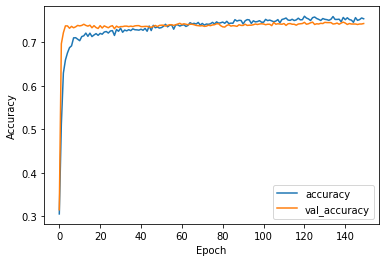

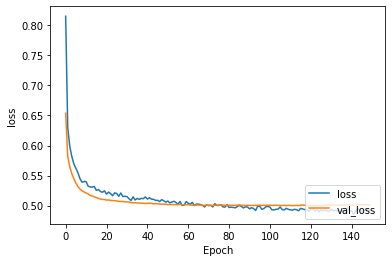

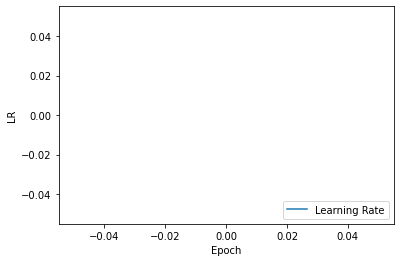

In [39]:
Plotter(acc,val_acc,loss,val_loss,l_r)

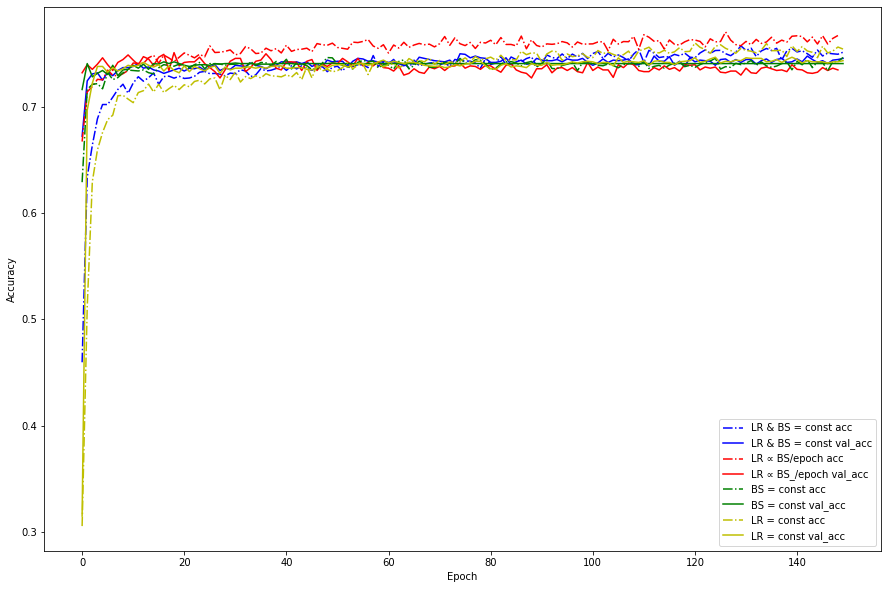

In [41]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1, label='LR & BS = const acc',ls='-.',c='b')
plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2, label='LR ∝ BS/epoch acc',ls='-.',c='r')
plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3, label='BS = const acc',ls='-.',c='g')
plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4, label='LR = const acc',ls='-.',c='y')
plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# case4_fashion_acc,case4_fashion_val_acc0